<a href="https://colab.research.google.com/github/jhlee93/Baseline/blob/main/ImageClassification/basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 구글드라이브 마운트

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 작업 경로 현재 디렉토리 경로로 변경

In [2]:
import os
# 경로 변경
os.chdir('/content/drive/MyDrive/Study/ImageClassification')

# 현재 경로 확인
!pwd
!ls

/content/drive/MyDrive/Study/ImageClassification
augmentation.ipynb  basic.ipynb     finger_numbers.zip
basic_best.h5	    finger_numbers


## tensorflow 및 기타 라이브러리 임포트

In [3]:
from glob import glob
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

## 데이터셋 준비

In [4]:
# # finger_numbers.zip를 finger_numbers 폴더에 압축 해제
# !unzip ./finger_numbers.zip -d ./finger_numbers

# # finger_numbers 디렉토리 확인
# !ls finger_numbers

In [5]:
# finger_numbers 데이터셋의 이미지는 모두 png 확장자
# glob 함수를 통해 png 확장자를 갖는 모든 학습 및 평가 데이터 경로를 리스트 형태로 담음
train_files = glob('./finger_numbers/train/*.png')
test_files = glob('./finger_numbers/test/*.png')
train_label = pd.read_csv('./finger_numbers/train_label.csv', header=None) # 컬럼 명칭이 없는 csv 데이터 이기 때문에 header=None 옵션을 통해 첫번째 행을 바로 데이터로 사용

# train_files, test_files 이미지 개수 확인
print('num train_files : ', len(train_files)) # 1000개
print('num test_files : ', len(test_files)) # 200개

# train_files, test_files 5개만 확인
print('train_files : ', train_files[:5])
print('test_files : ', test_files[:5])

# train_label 테이블 확인
train_label

num train_files :  1000
num test_files :  200
train_files :  ['./finger_numbers/train/train_010.png', './finger_numbers/train/train_061.png', './finger_numbers/train/train_060.png', './finger_numbers/train/train_015.png', './finger_numbers/train/train_037.png']
test_files :  ['./finger_numbers/test/test_091.png', './finger_numbers/test/test_129.png', './finger_numbers/test/test_125.png', './finger_numbers/test/test_163.png', './finger_numbers/test/test_175.png']


,0
0,5
1,0
2,2
3,5
4,2
...,...
995,4
996,4
997,5
998,1


In [6]:
# train_label과 순서를 맞추기 위해 정렬
train_files = sorted(train_files)
test_files = sorted(test_files)

# train_label 테이블에 컬럼 이름 label로 변경
train_label.columns = ['label']
train_label.head()

,label
0,5
1,0
2,2
3,5
4,2


In [7]:
# 학습 데이터의 클레스별 샘플 개수 확인
train_label['label'].value_counts()

1    169
0    169
2    168
4    167
5    165
3    162
Name: label, dtype: int64

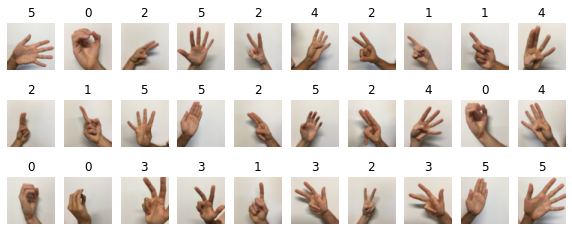

In [8]:
# 이미지와 레이블 확인
fig = plt.figure(figsize=(10,4))

for i, image_path in enumerate(train_files[:30]):
    ax = fig.add_subplot(3, 10, i+1) # 3행 10열로 구성된 subplots에서 [1행 1열, 1행 2열 ... ] 순으로 초기화를 진행

    img = plt.imread(image_path) # 이미지 파일 읽어오기
    ax.imshow(img) # 읽어온 이미지를 plot

    ax.set_title(train_label['label'][i]) # 해당 이미지의 레이블 값을 타이틀로 표기합니다.
    ax.set_axis_off()

plt.show()

In [9]:
# 이미지 shape 형태를 확인
sample_image = Image.open(train_files[0])
sample_image = np.array(sample_image)

print(sample_image.shape) # (H, W, C) = (세로, 가로, 채널)
print(sample_image.dtype) # uint8 0~255

(64, 64, 3)
uint8


## 데이터 전처리

In [10]:
# 2개의 이미지 shape을 확인
img0 = np.array(Image.open(train_files[0]))
img1 = np.array(Image.open(train_files[1]))
print(img0.shape, img1.shape)

# 1개의 array로 묶어주기 위해 맨 앞에 차원을 추가
img0 = np.expand_dims(img0, axis=0)
img1 = np.expand_dims(img1, axis=0)
print(img0.shape, img1.shape)

# 2개의 이미지를 1개의 array로 concatenate
concat_img01 = np.concatenate([img0, img1], axis=0)
print(concat_img01.shape) # (Batch, H, W, C)

(64, 64, 3) (64, 64, 3)
(1, 64, 64, 3) (1, 64, 64, 3)
(2, 64, 64, 3)


In [12]:
# 위와 같은 방법으로 학습 데이터 전체 1000개를 1개 배열로 concatenate
train_inputs = []
for file in train_files:
    img = Image.open(file)
    img = np.array(img)[:,:,:3] # image 가운데 A채널이 있는 4채널인 이미지들의 경우 3채널까지만 잘라줍니다.
    img = np.expand_dims(img, axis=0) # 전체 image를 하나의 array로 묶기 위해서 맨 앞에 차원을 하나 추가합니다.
    train_inputs.append(img)
train_inputs = np.concatenate(train_inputs, axis=0) # 전체를 하나의 array로 묶어줍니다.
print('train_inputs shape:', train_inputs.shape)

# 평가 데이터도 동일한 방식으로 전처리
test_inputs = []
for file in test_files:
    img = Image.open(file)
    img = np.array(img)[:,:,:3]
    img = np.expand_dims(img, axis=0)
    test_inputs.append(img)
test_inputs = np.concatenate(test_inputs, axis=0)
print('test_inputs shape:', test_inputs.shape)

train_inputs shape: (1000, 64, 64, 3)
test_inputs shape: (200, 64, 64, 3)


In [13]:
# 원본 이미지 값 확인
print('origin image')
print(train_inputs[0, :, :, 0])
print()

# 정규화
train_inputs = (train_inputs / 255).astype(np.float32)
test_inputs = (test_inputs / 255).astype(np.float32)

# 정규화된 이미지 값 확인
print('normalized')
print(train_inputs[0, :, :, 0])

origin image
[[227 227 227 ... 232 231 230]
 [227 227 228 ... 232 231 231]
 [227 227 227 ... 232 231 230]
 ...
 [119 124 127 ... 210 211 210]
 [119 124 126 ... 210 210 209]
 [119 123 122 ... 209 209 208]]

normalized
[[0.8901961  0.8901961  0.8901961  ... 0.9098039  0.90588236 0.9019608 ]
 [0.8901961  0.8901961  0.89411765 ... 0.9098039  0.90588236 0.90588236]
 [0.8901961  0.8901961  0.8901961  ... 0.9098039  0.90588236 0.9019608 ]
 ...
 [0.46666667 0.4862745  0.49803922 ... 0.8235294  0.827451   0.8235294 ]
 [0.46666667 0.4862745  0.49411765 ... 0.8235294  0.8235294  0.81960785]
 [0.46666667 0.48235294 0.47843137 ... 0.81960785 0.81960785 0.8156863 ]]


## 모델 구성하기

In [14]:
model = Sequential(name="my_sequential")
model.add(Conv2D(
    filters=32, # conv 필터를 통과한 32개의 피쳐맵을 출력
    kernel_size=(3,3),
    strides=(1,1),
    activation='relu', # relu: conv 필터를 통과한 피쳐맵을 0 이하의 값은 0으로
    input_shape=(64, 64, 3),
    padding='VALID')) # "VALID": 패딩을 적용하지 않음 conv필터 사이즈에 따라 입력 피쳐의 크기 감소 / "SAME": 패딩을 적용하여 필터 출력 피쳐의 크기를 유지
model.add(MaxPooling2D(pool_size=(2,2)))

# 64개 (3,3) conv 필터를 적용: (13,13,32) -> (11,11,64)
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))

# Dropout
model.add(Dropout(.5)) 

# (2,2) Maxpooling 적용: (11,11,64) -> (5,5,64) 마지막 1개는 버려짐
model.add(MaxPooling2D())

# (5,5,64) -> (3,3,64)
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))

# summary() 함수를 통해 확인
model.summary()

Model: "my_sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 29, 29, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)      

In [15]:
# Dense layer에 통과시키기 위해 마지막 conv layer 통과 후 (3,3,64)의 피쳐맵들을 1치원으로 펼침 --> 3x3x64=576
# Conv layer를 네트워크의 입력으로 사용하기 위해 행렬이 아닌 배열로 만들어 주는 과정
model.add(Flatten())

# Dense layer(Fully connected layer)를 추가
# Dense layer는 IN/OUTput을 모두 연결해주는 개념
# 1차적으로 펼쳐진 relu 활섬함수를 통해 576개의 피쳐들을 64개로
model.add(Dense(64, activation='relu'))

# 마지막 Dense layer는 64개의 피쳐들을 모델이 예측해야 할 클래스 갯수(6개 클래스)에 맞춘 후
# softmax 활성함수를 적용시켜 6개의 합이 1이 되도록 구성(가장 높은 값의 인덱스가 예측 클래스)
model.add(Dense(6, activation='softmax'))

model.summary()

Model: "my_sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 29, 29, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)      

In [16]:
# model = Sequential([
#     Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation='relu', input_shape=(64, 64, 3), padding='VALID'),
#     MaxPooling2D(pool_size=(2,2)),
#     Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
#     Dropout(.5),
#     MaxPooling2D(),
#     Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
#     Flatten(),
#     Dense(64, activation='relu'),
#     Dense(10, activation='softmax')
# ])
# model.summary()

In [17]:
# 모델 컴파일
model.compile(
    optimizer='adam',
    # loss 함수 설정
    # 여러개 중에서 하나를 찾는 다항분류 문제이기 때문에 categorical_crossentropy를 사용
    # 하지만 train_label 형태가 0,1,2,3,4,5 와 같은 정수 형태이기 때문에 'sparse_categorical_crossentropy'를 사용
    # 만약 train_label이 one-hot encoding 되어있다면 'categorical_crossentropy'를 사용
    loss='sparse_categorical_crossentropy',
    # 평가 메트릭
    metrics=['accuracy'])

# DataFrame 형태의 train_label를 학습을 위해 numpy 배열로 변환
train_label = train_label['label'].to_numpy()
print(train_label.shape)

# val_accuracy 성능이 가장 좋은 지점에서 모델 가중치를 저장
save_model_path='basic_best.h5'
ckpt = ModelCheckpoint(
    filepath=save_model_path,
    monitor='val_accuracy',
    save_best_only=True,
    verbose=True)

# 훈련 시작
epoch = 100
history = model.fit(
    x=train_inputs,
    y=train_label,
    validation_split=0.2,
    callbacks=[ckpt],
    batch_size=16,
    epochs=epoch)

(1000,)
Epoch 1/100
50/50 [==============================] - ETA: 0s - loss: 1.8084 - accuracy: 0.1762
Epoch 00001: val_accuracy improved from -inf to 0.16500, saving model to basic_best.h5
50/50 [==============================] - 15s 41ms/step - loss: 1.8084 - accuracy: 0.1762 - val_loss: 1.7876 - val_accuracy: 0.1650
Epoch 2/100
46/50 [==========================>...] - ETA: 0s - loss: 1.7057 - accuracy: 0.2840
Epoch 00002: val_accuracy improved from 0.16500 to 0.42500, saving model to basic_best.h5
50/50 [==============================] - 1s 15ms/step - loss: 1.6767 - accuracy: 0.2962 - val_loss: 1.4790 - val_accuracy: 0.4250
Epoch 3/100
50/50 [==============================] - ETA: 0s - loss: 1.1708 - accuracy: 0.5663
Epoch 00003: val_accuracy improved from 0.42500 to 0.62000, saving model to basic_best.h5
50/50 [==============================] - 1s 15ms/step - loss: 1.1708 - accuracy: 0.5663 - val_loss: 1.1476 - val_accuracy: 0.6200
Epoch 4/100
46/50 [==========================>...

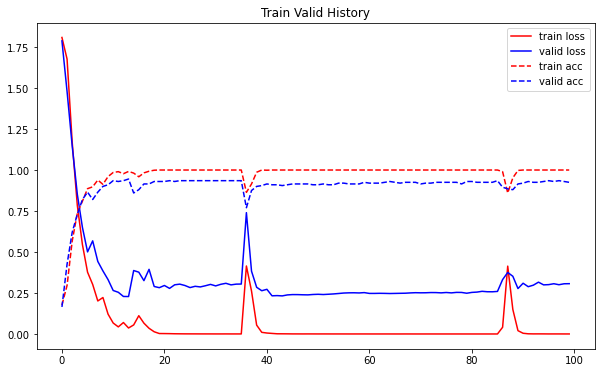

In [18]:
train_loss = history.history['loss']
valid_loss = history.history['val_loss']

train_acc = history.history['accuracy']
valid_acc = history.history['val_accuracy']

plt.figure(figsize=(10,6))
plt.plot(range(epoch), train_loss, label='train loss', c='r')
plt.plot(range(epoch), valid_loss, label='valid loss', c='b')
plt.plot(range(epoch), train_acc, '--', label='train acc', c='r')
plt.plot(range(epoch), valid_acc, '--', label='valid acc', c='b')
plt.title('Train Valid History')
plt.legend()
plt.show()

## 평가하기

pred label = 2


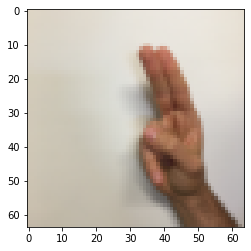

In [25]:
# 1개 평가 데이터 예측
test_sample = test_inputs[0]
plt.imshow(test_sample)

predict = model.predict(np.expand_dims(test_sample, 0))
print('pred label =', np.argmax(predict))

(4, 6)
[1.0000001 1.        1.        1.0000001]


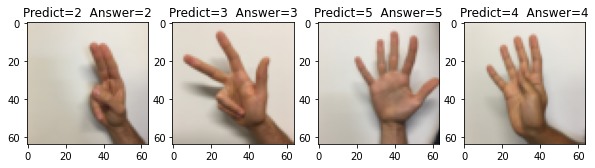

In [33]:
# 배치 단위 예측
test_samples = test_inputs[:4] # batch_size=4
predicts = model.predict(test_samples)
print(predicts.shape) # 4개 샘플에 대한 6개 클래스의 softmax 값으로 구성

# 각 샘플의 softmax 값의 합이 1이 되는지 확인
print(np.sum(predicts, axis=1))

# 정답 데이터
answer = pd.read_csv('./finger_numbers/answer.csv', header=None).to_numpy()


# 결과 확인
plt.figure(figsize=(10,4))
for i, p in enumerate(predicts):
    pred_label = np.argmax(p)
    gt_label = answer[i][0]
    ax = plt.subplot(1,4,i+1)
    ax.imshow(test_samples[i])
    ax.set_title(f'Predict={pred_label}  Answer={gt_label}')

plt.show()

In [36]:
test_loss, test_acc = model.evaluate(test_inputs, answer, batch_size=16)
print('test loss:', test_loss)
print('test acc: ', test_acc)

13/13 [==============================] - 0s 7ms/step - loss: 1.0801 - accuracy: 0.8050
test loss: 1.0801223516464233
test acc:  0.8050000071525574
